In [1]:
import os

import itertools
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn

from shapely.geometry import Point
import jismesh.utils as ju

import pyproj

In [2]:
def parse_time(timestamp):
    hour = timestamp // 3600
    minute = (timestamp % 3600) // 60
    seconds = (timestamp % 3600) % 60
    return hour, minute, seconds

def Coordinate2MeshCodePandas(lon, lat, level):

    return ju.to_meshcode(lat, lon, level).astype(int).astype(str)

from math import radians, cos, sin, asin, sqrt, ceil, log


R = 6371


def haversine(lon1, lat1, lon2, lat2):
    # UNIT: KILOMETER

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))

    return c * R

def mesh_distance(mesh_1, mesh_2):
    """

    :param mesh_1:
    :param mesh_2:
    :return:
    """
    lat1, lon1 = ju.to_meshpoint(mesh_1, 0.5, 0.5)
    lat2, lon2 = ju.to_meshpoint(mesh_2, 0.5, 0.5)

    return haversine(lon1, lat1, lon2, lat2)

def mesh_distance_df(row):
    return mesh_distance(row['origin_agg_key_cd'], row['destination_agg_key_cd'])

In [3]:
def mesh_pair_distance(m1, m2):
    """
    Return distance for central point of m1 and m2
    Args:
        m1: mesh id of m1
        m2: mesh id of m2
    Returns:
        d: distance
    """
    m1_lat, m1_lon = ju.to_meshpoint(m1, lat_multiplier=0.5, lon_multiplier=0.5)
    m2_lat, m2_lon = ju.to_meshpoint(m2, lat_multiplier=0.5, lon_multiplier=0.5)
    geodesic = pyproj.Geod(ellps='WGS84')
    faz, baz, d = geodesic.inv(m1_lon, m1_lat, m2_lon, m2_lat)
    d /= 1000.0
    return d

In [4]:
def calculate_mape(row):
    epsilon = 1e-8  
    seq1 = row[[f'vol_{i}_obs' for i in range(5, 24)]].values
    seq2 = row[[f'vol_{i}_ppf' for i in range(5, 24)]].values
    mape = np.mean(np.abs((seq1 - seq2) / (seq1 + epsilon))) * 100
    return mape

In [8]:
# toyama = pd.read_csv('/mnt/large/data/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')
toyama = pd.read_csv('C://large/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')
toyama = toyama.drop([len(toyama)-1], axis=0)
toyama = toyama.astype({'dt': 'str','mesh_cd': 'int64', 'od_class': 'int8', 'trip_class': 'int8', 'origin_agg_key_cd': 'int64', 'destination_agg_key_cd': 'int64', 'main_mode': 'int8' })

# shizuoka = pd.read_csv('/mnt/large/data/Softbank/21015_shizuoka_od_meshod_500m_daily.txt', names=toyama.columns, encoding='shift-jis')
shizuoka = pd.read_csv('C://large/Softbank/21015_shizuoka_od_meshod_500m_daily.txt', names=toyama.columns, encoding='shift-jis')
shizuoka = shizuoka.drop([len(shizuoka)-1], axis=0)
shizuoka = shizuoka.astype({'dt': 'str','mesh_cd': 'int64', 'od_class': 'int8', 'trip_class': 'int8', 'origin_agg_key_cd': 'int64', 'destination_agg_key_cd': 'int64', 'main_mode': 'int8' })

C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_11460\2672372256.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  toyama = pd.read_csv('C://large/Softbank/21015_toyama_od_meshod_500m_daily.txt', encoding='shift-jis')


## daily coverage

In [ ]:
t_coverage = pd.DataFrame(columns=['dt', 'Toyama'])
for group in toyama.groupby('dt'):
    t_coverage = t_coverage.append({'dt': group[0], 'Toyama': len(set(group[1]['destination_agg_key_name']))/1822}, ignore_index=True)

In [10]:
for group in shizuoka.groupby("dt"):
    # group[1].to_csv('/home/ubuntu/Data/SoftbankOD/shizuoka_'+group[0]+'_od_meshod_500m_daily.csv', index=False)
    group[1].to_csv('C://large/Softbank/shizuoka_'+group[0]+'_od_meshod_500m_daily.csv', index=False)

In [ ]:
for group in toyama.groupby("dt"):
    group[1].to_csv('/home/ubuntu/Data/SoftbankOD/toyama_'+group[0]+'_od_meshod_500m_daily.csv', index=False)

In [11]:
shizuoka = shizuoka[shizuoka['dt']=='20191015']
shizuoka

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people
1623911,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775983,513775983,90,＊
1623912,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775993,513775993,90,＊
1623913,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513776822,513776822,90,50.0
1623914,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,523705093,523705093,90,36.7
1623915,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,523705182,523705182,90,96.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2507665,20191015,静岡県,駿東郡 小山町,533900201,3,3,22342,駿東郡 長泉町,533900201,533900201,90,＊
2507666,20191015,静岡県,駿東郡 小山町,533900201,3,5,3,関東,533900201,533900201,20,60.1
2507667,20191015,静岡県,駿東郡 小山町,533900201,3,5,3,関東,533900201,533900201,30,19.7
2507668,20191015,静岡県,駿東郡 小山町,533900201,3,5,3,関東,533900201,533900201,90,47.5


In [12]:
shizuoka = shizuoka.replace('＊', 1)
shizuoka = shizuoka.astype({'total_people': 'float'})

In [9]:
toyama = toyama.replace('＊', 1)
toyama = toyama.astype({'total_people': 'float'})

In [13]:
shizuoka = shizuoka[shizuoka["od_class"]==2]
shizuoka = shizuoka[shizuoka["trip_class"]==2]

In [11]:
toyama = toyama[toyama["od_class"]==2]
toyama = toyama[toyama["trip_class"]==2]

In [14]:
shizuoka['origin_mesh_lv3'] = shizuoka['origin_agg_key_name'].astype(float) / 10
shizuoka['origin_mesh_lv3'] = shizuoka['origin_mesh_lv3'].astype(int)
shizuoka['destination_mesh_lv3'] = shizuoka['destination_agg_key_name'].astype(float) / 10
shizuoka['destination_mesh_lv3'] = shizuoka['destination_mesh_lv3'].astype(int)
shizuoka

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people,origin_mesh_lv3,destination_mesh_lv3
1623911,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775983,513775983,90,1.0,51377589,51377598
1623912,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775993,513775993,90,1.0,51377589,51377599
1623913,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513776822,513776822,90,50.0,51377589,51377682
1623914,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,523705093,523705093,90,36.7,51377589,52370509
1623915,20191015,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,523705182,523705182,90,96.8,51377589,52370518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507631,20191015,静岡県,駿東郡 小山町,533900201,2,2,533900201,533900201,533806293,533806293,90,1.0,53390020,53380629
2507632,20191015,静岡県,駿東郡 小山町,533900201,2,2,533900201,533900201,533807161,533807161,90,1.0,53390020,53380716
2507633,20191015,静岡県,駿東郡 小山町,533900201,2,2,533900201,533900201,533807382,533807382,90,1.0,53390020,53380738
2507634,20191015,静岡県,駿東郡 小山町,533900201,2,2,533900201,533900201,533807392,533807392,90,13.2,53390020,53380739


In [ ]:
toyama['origin_mesh_lv3'] = toyama['origin_agg_key_name'].astype(float) / 10
toyama['origin_mesh_lv3'] = toyama['origin_mesh_lv3'].astype(int)
toyama['destination_mesh_lv3'] = toyama['destination_agg_key_name'].astype(float) / 10
toyama['destination_mesh_lv3'] = toyama['destination_mesh_lv3'].astype(int)
toyama

In [16]:
shizuoka_lv3 = {}
idx = 0

for group in shizuoka.groupby(['dt', 'origin_mesh_lv3', 'destination_mesh_lv3']):

    dt = group[1]['dt'].tolist()[0]
    pref_name = group[1]['pref_name'].tolist()[0]
    city_name = group[1]['city_name'].tolist()[0]
    mesh_cd = group[1]['mesh_cd'].tolist()[0]
    od_class = group[1]['od_class'].tolist()[0]
    trip_class = group[1]['trip_class'].tolist()[0]
    origin_agg_key_cd = group[1]['origin_mesh_lv3'].tolist()[0]
    origin_agg_key_name = group[1]['origin_mesh_lv3'].tolist()[0]
    destination_agg_key_cd = group[1]['destination_mesh_lv3'].tolist()[0]
    destination_agg_key_name = group[1]['destination_mesh_lv3'].tolist()[0]
    total_people = sum(group[1]['total_people'].tolist())
#     {'dt':dt, 'pref_name':pref_name, 'city_name':city_name, 'mesh_cd':mesh_cd, 'od_class': od_class, 'trip_class': trip_class,
#                                        'origin_agg_key_cd':origin_agg_key_cd, 'origin_agg_key_name':origin_agg_key_name, 'destination_agg_key_cd':destination_agg_key_cd,
#                                        'destination_agg_key_name': destination_agg_key_name, 'total_people':total_people})
    shizuoka_lv3[idx] = [dt, pref_name, city_name, mesh_cd, od_class, trip_class, origin_agg_key_cd, origin_agg_key_name, destination_agg_key_cd, destination_agg_key_name, total_people]
    idx += 1
    if idx % 10000 == 0:
        print(idx)

# shizuoka_lv3

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [17]:
# 使用 groupby 和 agg 进行简化
shizuoka_lv3_df = (
    shizuoka.groupby(['dt', 'origin_mesh_lv3', 'destination_mesh_lv3'], as_index=False)
    .agg(
        pref_name=('pref_name', 'first'),
        city_name=('city_name', 'first'),
        mesh_cd=('mesh_cd', 'first'),
        od_class=('od_class', 'first'),
        trip_class=('trip_class', 'first'),
        origin_agg_key_cd=('origin_mesh_lv3', 'first'),
        origin_agg_key_name=('origin_mesh_lv3', 'first'),
        destination_agg_key_cd=('destination_mesh_lv3', 'first'),
        destination_agg_key_name=('destination_mesh_lv3', 'first'),
        total_people=('total_people', 'sum')
    )
)

shizuoka_lv3_df.reset_index(drop=True, inplace=True)

shizuoka_lv3_df

,dt,origin_mesh_lv3,destination_mesh_lv3,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,total_people
0,20191015,51377589,51377598,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,51377598,51377598,1.0
1,20191015,51377589,51377599,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,51377599,51377599,1.0
2,20191015,51377589,51377682,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,51377682,51377682,50.0
3,20191015,51377589,52370509,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,52370509,52370509,36.7
4,20191015,51377589,52370518,静岡県,浜松市 南区,513775893,2,2,51377589,51377589,52370518,52370518,96.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115141,20191015,53390020,53380629,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380629,53380629,1.0
115142,20191015,53390020,53380716,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380716,53380716,1.0
115143,20191015,53390020,53380738,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380738,53380738,1.0
115144,20191015,53390020,53380739,静岡県,駿東郡 小山町,533900201,2,2,53390020,53390020,53380739,53380739,13.2


<Axes: >

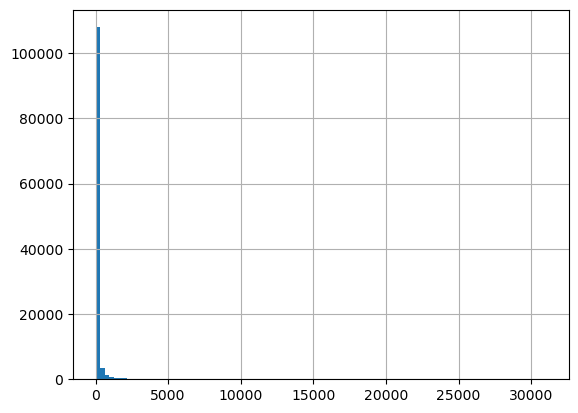

In [18]:
shizuoka_lv3_df['total_people'].hist(bins=100)

In [ ]:
toyama_lv3 = {}
idx = 0

for group in toyama.groupby(['dt', 'origin_mesh_lv3', 'destination_mesh_lv3']):

    dt = group[1]['dt'].tolist()[0]
    pref_name = group[1]['pref_name'].tolist()[0]
    city_name = group[1]['city_name'].tolist()[0]
    mesh_cd = group[1]['mesh_cd'].tolist()[0]
    od_class = group[1]['od_class'].tolist()[0]
    trip_class = group[1]['trip_class'].tolist()[0]
    origin_agg_key_cd = group[1]['origin_mesh_lv3'].tolist()[0]
    origin_agg_key_name = group[1]['origin_mesh_lv3'].tolist()[0]
    destination_agg_key_cd = group[1]['destination_mesh_lv3'].tolist()[0]
    destination_agg_key_name = group[1]['destination_mesh_lv3'].tolist()[0]
    total_people = sum(group[1]['total_people'].tolist())
#     {'dt':dt, 'pref_name':pref_name, 'city_name':city_name, 'mesh_cd':mesh_cd, 'od_class': od_class, 'trip_class': trip_class,
#                                        'origin_agg_key_cd':origin_agg_key_cd, 'origin_agg_key_name':origin_agg_key_name, 'destination_agg_key_cd':destination_agg_key_cd,
#                                        'destination_agg_key_name': destination_agg_key_name, 'total_people':total_people})
    toyama_lv3[idx] = [dt, pref_name, city_name, mesh_cd, od_class, trip_class, origin_agg_key_cd, origin_agg_key_name, destination_agg_key_cd, destination_agg_key_name, total_people]
    idx += 1
    if idx % 10000 == 0:
        print(idx)

toyama_lv3

In [20]:
df = pd.DataFrame.from_dict(shizuoka_lv3, orient='index', columns=['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class', 'origin_agg_key_cd', 'origin_agg_key_name', 'destination_agg_key_cd', 'destination_agg_key_name', 'total_people'])
df.to_csv('C://large/Softbank/shizuoka_OD_mesh_lv3.csv', index=False)

In [26]:
df2 = pd.DataFrame.from_dict(toyama_lv3, orient='index', columns=['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class', 'origin_agg_key_cd', 'origin_agg_key_name', 'destination_agg_key_cd', 'destination_agg_key_name', 'total_people'])
df2.to_csv('Toyama_OD_mesh_lv3.csv', index=False)

<AxesSubplot:>

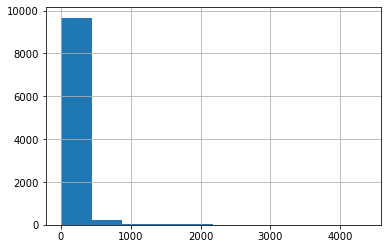

In [31]:
df2['total_people'][0:10000].hist()

In [21]:
date = ['20191013', '20191014', '20191015', '20191016', '20191017', '20191018', '20191019',
        '20201011', '20201012', '20201013', '20201014', '20201015', '20201016', '20201017']

In [22]:
shizuoka = shizuoka.replace('＊', 5)
shizuoka = shizuoka.astype({'total_people': 'float'})

In [ ]:
mesh = gpd.read_file('/home/ubuntu/Data/shapefile/shizuoka500mesh/500m_mesh_2018_22.shp')
mesh[['MESH_ID', 'SHICODE', 'PTN_2015', 'geometry']]
# mesh.columns
mesh_shicode ={}
for idx, row in mesh.iterrows():
    if row['MESH_ID'] not in mesh_shicode:
        mesh_shicode[row['MESH_ID']] = row['SHICODE']

In [60]:
code = pd.DataFrame.from_dict(mesh_shicode, orient='index').reset_index().rename(columns={'index': 'origin_agg_key_cd', 0: 'shicode'})

In [38]:
shizuoka_day = shizuoka[shizuoka['dt']=='20191013']
shizuoka_day

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people
0,20191013,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775983,513775983,90,5.0
1,20191013,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775984,513775984,90,5.0
2,20191013,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775992,513775992,90,12.1
3,20191013,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,513775993,513775993,90,57.5
4,20191013,静岡県,浜松市 南区,513775893,2,2,513775893,513775893,523705082,523705082,90,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
789995,20191013,静岡県,駿東郡 小山町,533900201,3,3,22215,御殿場市,533900201,533900201,20,11.4
789996,20191013,静岡県,駿東郡 小山町,533900201,3,3,22215,御殿場市,533900201,533900201,90,11.8
789997,20191013,静岡県,駿東郡 小山町,533900201,3,5,3,関東,533900201,533900201,20,19.8
789998,20191013,静岡県,駿東郡 小山町,533900201,3,5,3,関東,533900201,533900201,90,108.4


In [41]:
data = shizuoka_day[shizuoka_day['city_name'].isin(['静岡市 駿河区', '静岡市 葵区', '富士市', '浜松市 中区', '沼津市', '裾野市'])]
data = data[data['od_class']==2]
data = data[data['trip_class']==2]
data

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people
40988,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705274,523705274,90,1720.4
40989,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705281,523705281,90,155.6
40990,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705283,523705283,90,81.6
40991,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705363,523705363,90,15.4
40992,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705364,523705364,20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
730068,20191013,静岡県,裾野市,523877003,2,2,523877003,523877003,523867801,523867801,90,5.0
782289,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861464,523861464,90,52.5
782290,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861791,523861791,90,5.0
782291,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861991,523861991,90,100.0


In [66]:
data['dist'] = data.apply(mesh_distance_df, axis=1)

In [93]:
data

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people,dist
40988,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705274,523705274,90,1720.4,0.735672
40989,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705281,523705281,90,155.6,1.142929
40990,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705283,523705283,90,81.6,1.233240
40991,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705363,523705363,90,15.4,1.799448
40992,20191013,静岡県,浜松市 中区,523705271,2,2,523705271,523705271,523705364,523705364,20,5.0,1.502813
...,...,...,...,...,...,...,...,...,...,...,...,...,...
730068,20191013,静岡県,裾野市,523877003,2,2,523877003,523877003,523867801,523867801,90,5.0,2.316561
782289,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861464,523861464,90,52.5,14.640181
782290,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861791,523861791,90,5.0,12.046117
782291,20191013,静岡県,静岡市 葵区,533801091,2,2,533801091,533801091,523861991,523861991,90,100.0,10.192868


In [95]:
mesh_pair_distance(523705271, 523705281	)

1.1454520803571482

<AxesSubplot:xlabel='dist', ylabel='total_people'>

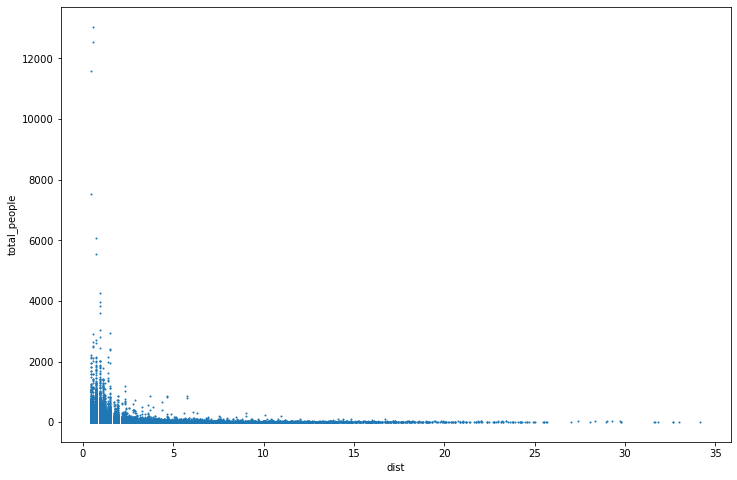

In [106]:
data[data['total_people']>1].plot.scatter(x='dist', y='total_people',s=1, figsize=(12,8))

<AxesSubplot:>

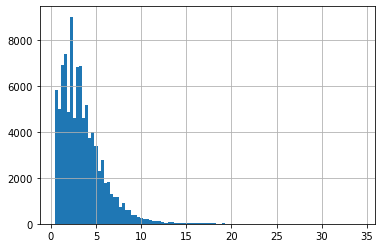

In [75]:
data['dist'].hist()

In [ ]:
data['total_people'].max()

In [9]:
shizuoka_day['city_name'].unique()

array(['浜松市 南区', '磐田市', '掛川市', '御前崎市', '菊川市', '牧之原市', '賀茂郡 南伊豆町', '下田市',
       '湖西市', '浜松市 西区', '浜松市 中区', '浜松市 東区', '袋井市', '浜松市 北区', '浜松市 浜北区',
       '周智郡 森町', '浜松市 天竜区', '榛原郡 吉田町', '賀茂郡 松崎町', '賀茂郡 河津町', '島田市', '藤枝市',
       '焼津市', '賀茂郡 西伊豆町', '賀茂郡 東伊豆町', '伊豆市', '静岡市 駿河区', '榛原郡 川根本町',
       '静岡市 葵区', '静岡市 清水区', '沼津市', '伊豆の国市', '田方郡 函南町', '駿東郡 清水町', '三島市',
       '富士市', '富士宮市', '駿東郡 長泉町', '裾野市', '御殿場市', '駿東郡 小山町', '伊東市', '熱海市'],
      dtype=object)

In [100]:
len(data[data['city_name']== '富士市'])*0.8

25785.600000000002

<AxesSubplot:>

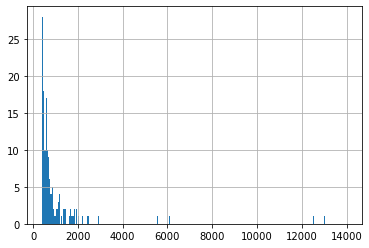

In [101]:
data[data['city_name']=='静岡市 葵区']['total_people'].hist(range=(400,14000),bins=400)

<AxesSubplot:>

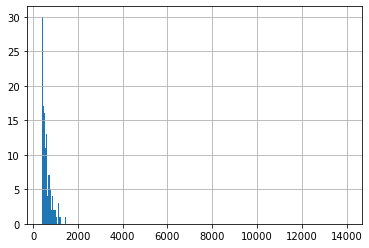

In [49]:
data[data['city_name']=='富士市']['total_people'].hist(range=(400,14000),bins=400)

<AxesSubplot:>

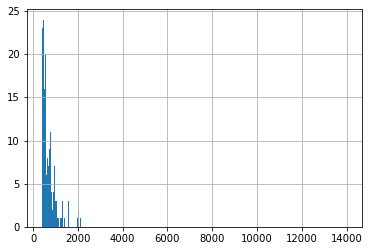

In [108]:
data[data['city_name']=='静岡市 駿河区']['total_people'].hist(range=(400,14000),bins=400)

<AxesSubplot:>

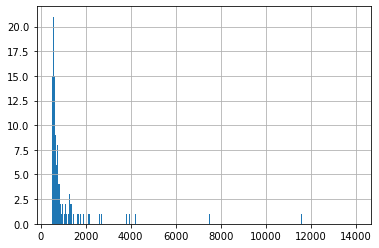

In [107]:
data[data['city_name']=='沼津市']['total_people'].hist(range=(500,14000),bins=400)

<AxesSubplot:>

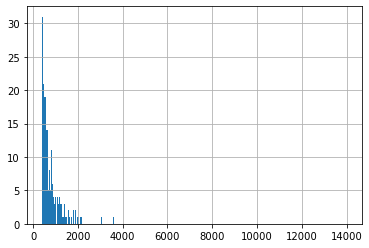

In [58]:
data[data['city_name']=='浜松市 中区']['total_people'].hist(range=(400,14000),bins=400)

<AxesSubplot:>

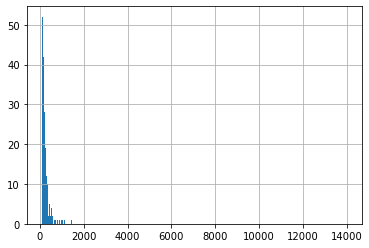

In [56]:
data[data['city_name']=='裾野市']['total_people'].hist(range=(100,14000),bins=400)

In [ ]:
shizuoka_day = pd.merge(shizuoka_day, code, how='left').rename(columns={'shicode': 'origin_shicode'})
# set(shizuoka_day['origin_shicode'].tolist())

In [57]:
code = code.rename(columns={'origin_agg_key_cd': 'destination_agg_key_cd'})
shizuoka = pd.merge(shizuoka, code, on='destination_agg_key_cd').rename(columns={'shicode': 'destination_shicode'})

In [58]:
shizuoka = shizuoka[['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class',
       'origin_agg_key_cd', 'origin_shicode', 'destination_agg_key_cd',
       'destination_shicode', 'main_mode', 'total_people']]

In [80]:
shizuoka_day[shizuoka_day['origin_shicode']==22101]['destination_shicode'].tolist()

[22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,
 22101,


In [77]:
for group in shizuoka_day.groupby(['origin_shicode', 'destination_shicode']):
    print(group[0])
    #print(group[1])
    #print(sum(group[1]['total_people']))
    #break

(22101, 22101)
(22101, 22103)
(22102, 22102)
(22103, 22101)
(22103, 22103)
(22131, 22131)
(22131, 22132)
(22131, 22133)
(22131, 22134)
(22132, 22131)
(22132, 22132)
(22132, 22136)
(22133, 22131)
(22133, 22133)
(22133, 22135)
(22134, 22131)
(22134, 22134)
(22135, 22133)
(22135, 22135)
(22135, 22136)
(22136, 22132)
(22136, 22135)
(22136, 22136)
(22136, 22137)
(22137, 22136)
(22137, 22137)
(22203, 22203)
(22203, 22342)
(22205, 22205)
(22206, 22206)
(22206, 22220)
(22206, 22325)
(22207, 22207)
(22207, 22210)
(22208, 22208)
(22209, 22209)
(22209, 22424)
(22210, 22207)
(22210, 22210)
(22211, 22211)
(22211, 22216)
(22212, 22212)
(22212, 22214)
(22213, 22213)
(22213, 22216)
(22213, 22224)
(22214, 22212)
(22214, 22214)
(22215, 22215)
(22215, 22344)
(22216, 22211)
(22216, 22213)
(22216, 22216)
(22216, 22461)
(22219, 22219)
(22220, 22206)
(22220, 22220)
(22220, 22342)
(22221, 22221)
(22222, 22222)
(22222, 22225)
(22223, 22223)
(22224, 22213)
(22224, 22216)
(22224, 22224)
(22224, 22226)
(22225, 22

In [72]:
len(shizuoka_day.groupby(['origin_shicode', 'destination_shicode']))

94

## Check

In [109]:
count = 0
for group in toyama[(toyama['dt']=='20191013')].groupby(['origin_agg_key_cd', 'destination_agg_key_cd']):
    
    if len(group[1]) > 1:
        print(group[1])
        count += 1 
    if count == 100:
        break

             dt pref_name city_name    mesh_cd  od_class  trip_class  \
43884  20191013       富山県       富山市  543771651         3           5   
43885  20191013       富山県       富山市  543771651         3           5   

       origin_agg_key_cd origin_agg_key_name  destination_agg_key_cd  \
43884                  1                 北海道               543771651   
43885                  1                 北海道               543771651   

      destination_agg_key_name  main_mode total_people  
43884                543771651         60            ＊  
43885                543771651         90            ＊  
             dt pref_name city_name    mesh_cd  od_class  trip_class  \
47070  20191013       富山県       富山市  543771753         3           5   
47071  20191013       富山県       富山市  543771753         3           5   

       origin_agg_key_cd origin_agg_key_name  destination_agg_key_cd  \
47070                  1                 北海道               543771753   
47071                  1          

In [17]:
for k,v in shizuoka[shizuoka['dt']=='20191013']['destination_agg_key_cd'].value_counts().items():
    print(k, v)

23 4414
3 4117
22101 3670
22203 3601
22103 3522
22102 3308
22210 3239
22131 3123
22132 3043
22213 2894
22211 2862
22214 2616
22209 2394
22136 2382
22212 2269
22216 2155
22206 2125
22135 2123
22133 2120
22215 1929
22134 1828
22207 1822
22226 1760
22220 1724
5 1588
22224 1556
22342 1536
22225 1480
22325 1424
22341 1405
22221 1282
22424 1162
22461 1121
22222 1074
22344 982
22137 904
22223 867
22208 866
21 802
22205 754
7 617
24 589
523855843 574
523855942 550
523855851 538
523855943 531
523706483 527
523855814 523
523855931 521
523855834 515
523855734 508
523855923 503
523856473 491
523833613 491
523833702 477
523810211 477
523706584 474
523843293 473
523865022 469
523856284 464
523855944 461
523855714 456
523706782 450
523855953 450
523865041 446
523856282 443
523865322 439
523855854 436
523864791 436
523843382 434
523833604 434
523856494 432
523706973 432
523856373 424
523833611 421
523865222 419
523865032 418
523864984 418
523865031 417
523705484 417
523865243 416
523843191 415
5238650

## Statistics

In [95]:
for day_od in toyama.groupby('dt'):
    print(day_od[0])
    print('Data volume:',len(day_od[1]))
    print('Ratio of ＊:', len(day_od[1][day_od[1]['total_people']=='＊']) / len(day_od[1]))
    print('Raion of Intracity OD:', len(day_od[1][(day_od[1]['origin_agg_key_cd']>10)&(day_od[1]['destination_agg_key_cd']>10)]) / len(day_od[1]))
    print('Raion of Inner Zone OD:', len(day_od[1][day_od[1]['trip_class']==5]) / len(day_od[1]))

20191013
Data volume: 275221
Ratio of ＊: 0.6303552417875089
Raion of Intracity OD: 0.9911707318845582
Raion of Inner Zone OD: 0.008854702221124115
20191014
Data volume: 277628
Ratio of ＊: 0.6340606855216333
Raion of Intracity OD: 0.988873600645468
Raion of Inner Zone OD: 0.01113000129669918
20191015
Data volume: 320881
Ratio of ＊: 0.6416490848632359
Raion of Intracity OD: 0.9926545978104032
Raion of Inner Zone OD: 0.0073485186097026626
20191016
Data volume: 318551
Ratio of ＊: 0.6398535870237418
Raion of Intracity OD: 0.9928143374216374
Raion of Inner Zone OD: 0.00719508022263311
20191017
Data volume: 321163
Ratio of ＊: 0.6418734412120948
Raion of Intracity OD: 0.9923777022882462
Raion of Inner Zone OD: 0.007622297711753844
20191018
Data volume: 323168
Ratio of ＊: 0.6459581394197446
Raion of Intracity OD: 0.9915183434003366
Raion of Inner Zone OD: 0.008490939696999702
20191019
Data volume: 302437
Ratio of ＊: 0.6359903054189798
Raion of Intracity OD: 0.9897896090756091
Raion of Inner Zon

In [96]:
for day_od in shizuoka.groupby('dt'):
    print(day_od[0])
    print('Data volume:',len(day_od[1]))
    print('Ratio of ＊:', len(day_od[1][day_od[1]['total_people']=='＊']) / len(day_od[1]))
    print('Raion of Intracity OD:', len(day_od[1][(day_od[1]['origin_agg_key_cd']>10)&(day_od[1]['destination_agg_key_cd']>10)]) / len(day_od[1]))
    print('Raion of Inner Zone OD:', len(day_od[1][day_od[1]['trip_class']==5]) / len(day_od[1]))

20191013
Data volume: 790000
Ratio of ＊: 0.633553164556962
Raion of Intracity OD: 0.9819012658227848
Raion of Inner Zone OD: 0.0181
20191014
Data volume: 833911
Ratio of ＊: 0.6466445460007123
Raion of Intracity OD: 0.9769160018275331
Raion of Inner Zone OD: 0.023089994016148006
20191015
Data volume: 883759
Ratio of ＊: 0.6497766925145882
Raion of Intracity OD: 0.9802514033803333
Raion of Inner Zone OD: 0.019755385800880106
20191016
Data volume: 884294
Ratio of ＊: 0.6492343044281653
Raion of Intracity OD: 0.9799093966486259
Raion of Inner Zone OD: 0.020095126733869054
20191017
Data volume: 866082
Ratio of ＊: 0.651999464253962
Raion of Intracity OD: 0.9795111779254159
Raion of Inner Zone OD: 0.020489976699665853
20191018
Data volume: 887412
Ratio of ＊: 0.6475109644674627
Raion of Intracity OD: 0.9786581655420481
Raion of Inner Zone OD: 0.021347468819443504
20191019
Data volume: 848462
Ratio of ＊: 0.6383550471323406
Raion of Intracity OD: 0.9759659242252452
Raion of Inner Zone OD: 0.024041

In [9]:
toyama = toyama.replace('＊', random.randrange(10))
toyama = toyama.astype({'total_people': float})

In [13]:
for day_od in toyama.groupby('dt'):
#                     print(day_od[0])
#                     print(len(day_od[1]))
    print(sum(day_od[1]['total_people']))

9619121.89999925
9344046.599999204
10385612.699998887
10295457.29999918
10206010.099998964
10122822.199999155
9967145.399999158
9197222.599999433
10149457.09999937
10046899.599999197
9899936.099999016
10302535.29999921
10158095.399999185
9959249.199999636


In [93]:
pop = pd.DataFrame()

for noise in range(0, 10):
    toyama_noise = toyama.replace('＊', noise)
    toyama_noise = toyama_noise.astype({'total_people': float})
    
    for group in toyama_noise.groupby('dt'):
        pop.loc[group[0], noise] = sum(group[1]['total_people'])
        
toyama_noise = toyama.replace('＊', random.randrange(10))
toyama_noise = toyama_noise.astype({'total_people': float})

for group in toyama_noise.groupby('dt'):
    pop.loc[group[0], 'random'] = sum(group[1]['total_people'])
pop

,0,1,2,3,4,5,6,7,8,9,random
20191013,8.925174e+06,9.098661e+06,9.272148e+06,9.445635e+06,9.619122e+06,9.792609e+06,9.966096e+06,1.013958e+07,1.031307e+07,1.048656e+07,8.925174e+06
20191014,8.639915e+06,8.815948e+06,8.991981e+06,9.168014e+06,9.344047e+06,9.520080e+06,9.696113e+06,9.872146e+06,1.004818e+07,1.022421e+07,8.639915e+06
20191015,9.562041e+06,9.767934e+06,9.973827e+06,1.017972e+07,1.038561e+07,1.059151e+07,1.079740e+07,1.100329e+07,1.120918e+07,1.141508e+07,9.562041e+06
20191016,9.480153e+06,9.683979e+06,9.887805e+06,1.009163e+07,1.029546e+07,1.049928e+07,1.070311e+07,1.090694e+07,1.111076e+07,1.131459e+07,9.480153e+06
20191017,9.381426e+06,9.587572e+06,9.793718e+06,9.999864e+06,1.020601e+07,1.041216e+07,1.061830e+07,1.082445e+07,1.103059e+07,1.123674e+07,9.381426e+06
20191018,9.287810e+06,9.496563e+06,9.705316e+06,9.914069e+06,1.012282e+07,1.033158e+07,1.054033e+07,1.074908e+07,1.095783e+07,1.116659e+07,9.287810e+06
20191019,9.197757e+06,9.390104e+06,9.582451e+06,9.774798e+06,9.967145e+06,1.015949e+07,1.035184e+07,1.054419e+07,1.073653e+07,1.092888e+07,9.197757e+06
20201011,8.496183e+06,8.671443e+06,8.846703e+06,9.021963e+06,9.197223e+06,9.372483e+06,9.547743e+06,9.723003e+06,9.898263e+06,1.007352e+07,8.496183e+06
20201012,9.323657e+06,9.530107e+06,9.736557e+06,9.943007e+06,1.014946e+07,1.035591e+07,1.056236e+07,1.076881e+07,1.097526e+07,1.118171e+07,9.323657e+06
20201013,9.211420e+06,9.420290e+06,9.629160e+06,9.838030e+06,1.004690e+07,1.025577e+07,1.046464e+07,1.067351e+07,1.088238e+07,1.109125e+07,9.211420e+06


In [94]:
pop[9] / pop[0]

20191013    1.174941
20191014    1.183370
20191015    1.193791
20191016    1.193503
20191017    1.197765
20191018    1.202284
20191019    1.188211
20201011    1.185653
20201012    1.199283
20201013    1.204076
20201014    1.204336
20201015    1.198155
20201016    1.205789
20201017    1.188392
dtype: float64

<AxesSubplot:>

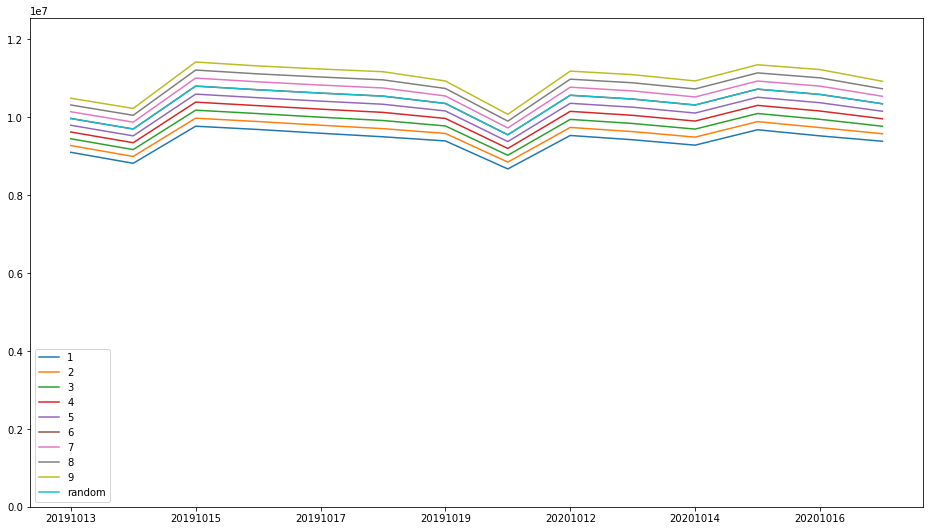

In [90]:
pop.plot(figsize=(16, 9), ylim=[0, max(pop[9])*1.1])

In [71]:
record = pd.DataFrame()
record.loc['20211901', 1] = 1
record.loc['20211901', 2] = 2
record

,1,2
20211901,1.0,2.0


## Merge

In [32]:
for dt in date:
    data = {}
    idx = 0
    for group in toyama[toyama['dt']==dt].groupby(['origin_agg_key_cd', 'destination_agg_key_cd']):
        data[idx] = [group[0][0], group[0][1], group[1]['total_people'].sum()]
        idx += 1
        if idx % 10000 == 0:
            print(dt, ' processed', idx, 'lines')
            print(data)
    df = pd.DataFrame()
    df = df.from_dict(data, orient='index')
    df.columns = ['origin', 'destination', 'volume']
    df.to_csv('Softbank/Toyama_OD_'+dt+'.csv', index=False)

20191013  processed 10000 lines
{0: [1, 543771651, 8.0], 1: [1, 543771742, 4.0], 2: [1, 543771743, 4.0], 3: [1, 543771753, 61.3], 4: [1, 543771823, 4.0], 5: [1, 543771951, 4.0], 6: [1, 543771953, 4.0], 7: [1, 553627291, 4.0], 8: [1, 553700471, 4.0], 9: [1, 553701053, 4.0], 10: [1, 553701161, 4.0], 11: [1, 553701164, 4.0], 12: [1, 553701462, 4.0], 13: [1, 553701774, 4.0], 14: [1, 553701884, 4.0], 15: [1, 553702493, 4.0], 16: [1, 553735701, 4.0], 17: [2, 543677562, 4.0], 18: [2, 543677564, 4.0], 19: [2, 553627291, 4.0], 20: [2, 553700274, 4.0], 21: [2, 553700353, 4.0], 22: [2, 553700912, 4.0], 23: [2, 553701283, 4.0], 24: [2, 553701364, 4.0], 25: [2, 553701471, 4.0], 26: [2, 553713033, 47.0], 27: [2, 553723042, 4.0], 28: [2, 553734454, 4.0], 29: [2, 553734684, 4.0], 30: [2, 553734691, 52.2], 31: [3, 543667741, 4.0], 32: [3, 543676792, 75.0], 33: [3, 543677661, 4.0], 34: [3, 543677941, 4.0], 35: [3, 543677981, 4.0], 36: [3, 543770053, 18.9], 37: [3, 543771541, 4.0], 38: [3, 543771554, 8.0

KeyboardInterrupt: 

## Comparison

In [47]:
dfs = {}
for dt in date:
    print(dt)
    df = pd.read_csv('Softbank/Toyama_OD_'+dt+'.csv')
    df = df.rename(columns={'origin':'origin_agg_key_cd', 'destination':'destination_agg_key_cd', 'volume': 'pop_'+dt})
    dfs[dt] = df
#     for group in df.groupby(['origin', 'destination']):
#         if len(group[1]) > 1:
#             print(group[1])

20191013
20191014
20191015
20191016
20191017
20191018
20191019
20201011
20201012
20201013
20201014
20201015
20201016
20201017


In [30]:
# data = toyama[toyama['trip_class'].isin([1, 2])]
# data = data[['dt', 'origin_agg_key_cd', 'destination_agg_key_cd', 'total_people']]
# data = data.reset_index(drop=True)

# dfs = {}
# for group in data.groupby('dt'):
#     df = group[1].drop(['dt'], axis=1)
#     df = df.rename(columns={'origin':'origin_agg_key_cd', 'destination':'destination_agg_key_cd','total_people': 'pop_'+str(group[0])})
#     dfs[group[0]] = df

In [21]:
dfs.keys()

dict_keys(['20191013', '20191014', '20191015', '20191016', '20191017', '20191018', '20191019', '20201011', '20201012', '20201013', '20201014', '20201015', '20201016', '20201017'])

In [48]:
df1 = pd.merge(dfs['20191013'], dfs['20191014'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df1 = df1.drop_duplicates()
df2 = pd.merge(df1, dfs['20191015'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df2 = df2.drop_duplicates()
df3 = pd.merge(df2, dfs['20191016'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df3 = df3.drop_duplicates()
df4 = pd.merge(df3, dfs['20191017'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df4 = df4.drop_duplicates()
df5 = pd.merge(df4, dfs['20191018'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df5 = df5.drop_duplicates()
df6 = pd.merge(df5, dfs['20191019'], on=['origin_agg_key_cd', 'destination_agg_key_cd'])
df6 = df6.drop_duplicates()

In [50]:
# combine = df6.replace('＊', 5.0).reset_index(drop=True)
combine = df6.reset_index(drop=True)
combine = combine.fillna(0)

In [58]:
combine = combine.astype({'origin_agg_key_cd': str, 'destination_agg_key_cd':str, 
                          'pop_20191013': float, 'pop_20191014': float, 'pop_20191015': float, 
                          'pop_20191016': float, 'pop_20191017': float, 'pop_20191018': float,
                          'pop_20191019': float})
combine.dtypes

origin_agg_key_cd          object
destination_agg_key_cd     object
pop_20191013              float64
pop_20191014              float64
pop_20191015              float64
pop_20191016              float64
pop_20191017              float64
pop_20191018              float64
pop_20191019              float64
std                       float64
var                       float64
mean                      float64
dtype: object

In [52]:
for group in combine.groupby(['origin_agg_key_cd', 'destination_agg_key_cd']):
    if len(group[1]) > 1:
        print(group[1])

In [61]:
combine['std'] = combine[['pop_20191013', 'pop_20191014', 'pop_20191015', 'pop_20191016', 'pop_20191017', 'pop_20191018', 'pop_20191019']].std(axis=1, numeric_only=True)
combine['var'] = combine[['pop_20191013', 'pop_20191014', 'pop_20191015', 'pop_20191016', 'pop_20191017', 'pop_20191018', 'pop_20191019']].var(axis=1, numeric_only=True)
combine['mean'] = combine[['pop_20191013', 'pop_20191014', 'pop_20191015', 'pop_20191016', 'pop_20191017', 'pop_20191018', 'pop_20191019']].mean(axis=1, numeric_only=True)

In [64]:
combine.sort_values('std', ascending=False)

,origin_agg_key_cd,destination_agg_key_cd,pop_20191013,pop_20191014,pop_20191015,pop_20191016,pop_20191017,pop_20191018,pop_20191019,std,var,mean
41532,553711102,553710094,25872.6,21260.4,21342.8,22332.4,20954.0,24690.0,11423.8,4671.099760,2.181917e+07,21125.142857
14093,543771933,553701032,2292.2,1993.0,3493.6,2737.0,5192.6,6371.4,13682.2,4102.440741,1.683002e+07,5108.857143
22642,553700711,553700714,13237.8,12466.8,4795.6,5944.0,4226.4,4940.8,9046.2,3792.932650,1.438634e+07,7808.228571
23747,553700821,553700824,17864.0,24726.6,25849.2,21599.4,22351.0,17685.0,18743.8,3292.118084,1.083804e+07,21259.857143
22786,553700714,553700711,11732.2,11407.2,4947.2,5602.8,3734.8,5168.2,7938.6,3228.684588,1.042440e+07,7218.714286
...,...,...,...,...,...,...,...,...,...,...,...,...
32580,553701633,553701211,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.000000,0.000000e+00,8.000000
17784,553607682,553607283,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.000000,0.000000e+00,8.000000
19225,553617181,553617092,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.000000,0.000000e+00,8.000000
41249,553711054,543771754,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.000000,0.000000e+00,8.000000


correlation coefficient: 0.8983902584714561


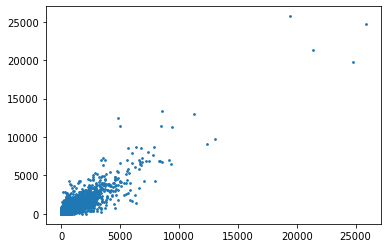

In [57]:
plt.scatter(combine['pop_20191015'], combine['pop_20191014'], s=3, marker='o')
print('correlation coefficient:', np.corrcoef(combine['pop_20191014'].values.flatten(), combine['pop_20191015'].values.flatten())[0][1])

In [97]:
### combine[(combine['pop_20191015'] - combine['pop_20191014'])>4000]

,origin_agg_key_cd,destination_agg_key_cd,pop_20191013,pop_20191014,pop_20191015,pop_20191016,pop_20191017,pop_20191018,pop_20191019,std,var,mean
14306,543771951,543771963,6086.6,1644.8,6032.2,3562.6,3454.4,4511.0,3278.6,1594.511088,2.542466e+06,4081.457143
14631,543771963,543771951,3815.8,1367.8,6376.6,3484.0,4119.8,6143.6,3393.0,1721.655792,2.964099e+06,4100.085714
23845,553700824,553700821,22171.0,19717.8,24735.8,22839.8,20344.8,19480.4,15494.2,2963.865703,8.784500e+06,20683.400000
36295,553702491,553702194,3449.8,1799.4,5841.2,5346.2,1913.2,2519.8,4268.0,1622.482990,2.632451e+06,3591.085714


In [8]:
combine[(combine['origin_agg_key_cd']=='543771431')&(combine['destination_agg_key_cd']=='543771233')]

NameError: name 'combine' is not defined

In [72]:
data[(data['origin_agg_key_cd']==553711102)&(data['destination_agg_key_cd']==553710094)]

,dt,origin_agg_key_cd,destination_agg_key_cd,total_people
195120,20191013,553711102,553710094,12936.3
209902,20191013,553711102,553710094,12936.3
426211,20191014,553711102,553710094,36.1
426212,20191014,553711102,553710094,10594.1
440671,20191014,553711102,553710094,36.1
440672,20191014,553711102,553710094,10594.1
693076,20191015,553711102,553710094,＊
693077,20191015,553711102,553710094,10667.4
710862,20191015,553711102,553710094,＊
710863,20191015,553711102,553710094,10667.4


In [73]:
od[(od['origin_agg_key_cd']==553711102)&(od['destination_agg_key_cd']==553710094)]

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,main_mode,total_people
227327,20191013,富山県,射水市,553710094.0,3.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,12936.3
244620,20191013,富山県,射水市,553711102.0,2.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,12936.3
502849,20191014,富山県,射水市,553710094.0,3.0,2.0,553711102.0,553711102,553710094.0,553710094,20.0,36.1
502850,20191014,富山県,射水市,553710094.0,3.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,10594.1
519900,20191014,富山県,射水市,553711102.0,2.0,2.0,553711102.0,553711102,553710094.0,553710094,20.0,36.1
519901,20191014,富山県,射水市,553711102.0,2.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,10594.1
814834,20191015,富山県,射水市,553710094.0,3.0,2.0,553711102.0,553711102,553710094.0,553710094,20.0,＊
814835,20191015,富山県,射水市,553710094.0,3.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,10667.4
835453,20191015,富山県,射水市,553711102.0,2.0,2.0,553711102.0,553711102,553710094.0,553710094,20.0,＊
835454,20191015,富山県,射水市,553711102.0,2.0,2.0,553711102.0,553711102,553710094.0,553710094,90.0,10667.4


In [11]:
for group in combine.groupby('origin_agg_key_cd'):
    print(group[1])
    break

   origin_agg_key_cd  destination_agg_key_cd pop_20191013 pop_20191014  \
0          543647603               543647703        473.0        723.5   

  pop_20191015 pop_20191016 pop_20191017 pop_20191018 pop_20191019  
0        471.8        666.3        468.0        558.4        406.9  


In [146]:
for gdfs['20191019']

,origin_agg_key_cd,destination_agg_key_cd,pop_20191019
1836612,543646574,543646783,50.0
1836613,543646783,543657222,＊
1836614,543646783,6,50.0
1836615,543646783,6,＊
1836616,543646574,543646783,50.0
...,...,...,...
2139044,15,553735701,313.1
2139045,2,553735701,＊
2139046,5,553735701,＊
2139047,5,553735701,10.9


## Classification

In [93]:
data = od[['trip_class', 'origin_agg_key_cd', 'destination_agg_key_cd', 'main_mode', 'total_people']]
data = data[data['trip_class'].isin([1, 2])]
data = data.drop(['trip_class'], axis=1)
data = data.reset_index(drop=True)

In [82]:
locs = list(set(data['destination_agg_key_cd'].tolist()+data['origin_agg_key_cd'].tolist()))

In [91]:
len(data) / count

0.3182557714498685

In [97]:
for group in data.groupby('origin_agg_key_cd'):
    print(len(group[1]))

34
44
4
20
380
10
330
404
16
22
2
8
2
2
212
142
68
56
1218
4
12
14
504
220
452
408
254
326
380
172
16
80
2
410
376
4
172
12
4
2
260
12
6
310
4
538
134
66
284
538
1300
1070
2
24
2
258
870
8
88
460
2
4
774
192
12
614
2062
2
208
50
2
1380
32
480
556
6
964
572
1114
1968
642
620
1566
40
818
2400
50
1302
32
652
100
358
66
30
878
1334
2318
52
10
32
1284
18
714
1248
1154
296
38
1526
16
166
6
1430
1200
370
1734
530
1568
1440
276
426
2
258
298
1952
1204
1456
210
34
1724
332
1292
548
540
10
340
218
2284
16
114
154
352
436
1492
16
26
1390
288
268
1740
748
26
2138
1882
38
264
1870
964
10
1900
1262
12
1360
30
30
1068
4
826
34
646
62
844
1074
1320
984
18
1334
44
1514
990
1498
1488
26
922
1026
846
782
248
480
864
1152
78
2
24
174
276
506
60
532
8
232
68
18
48
48
124
76
78
16
74
58
266
196
8
56
386
28
36
172
54
130
98
172
486
24
12
424
40
38
6
108
38
4
8
1300
400
16
284
74
100
252
2
1138
28
26
22
420
968
1020
1456
42
28
1156
1074
1158
774
40
20
2060
16
2030
1166
1068
1442
1206
8
576
2
14
342
1150
578
6

## PT process

In [10]:
def major_mode(lst):
    mode_types = [i for i in range(24, 0, -1)]
    mode_types.insert(0, 77)
    
    mode = 99
    
    for m in mode_types:
        if m in lst:
            mode = m
            break

    return mode

def od_counter(path, zones, od_volume):
    df = pd.read_csv(path, names=['PID', 'TNO', 'SNO', 'PDATE', 'LON', 'LAT', 'SEX', 'AGE', 'PADD', 'WORK', 'PURPOSE', 'MAGFAC', 'MAGFAC2', 'DATUM'])
    # od_volume = pd.DataFrame(columns=['origin', 'destination', 'purpose', 'mode', 'total_pop'])
    
    try:
        for group in df.groupby('TNO'):
            sRecord, eRecord = group[1].iloc[0], group[1].iloc[-1]
            if sRecord['DATUM']!= 97:
                slon, slat = sRecord['LON'], sRecord['LAT']
                p_start = gpd.GeoSeries(Point(slon, slat))
                ozone = zones[zones.contains(p_start.geometry.iloc[0])]['ZONE_ID'].values[0] #.index.values[0]
                elon, elat = eRecord['LON'], eRecord['LAT']
                p_end = gpd.GeoSeries(Point(elon, elat))
                dzone = zones[zones.contains(p_end.geometry.iloc[0])]['ZONE_ID'].values[0] #.index.values[0]
                magfac = sRecord['MAGFAC']
                # mode = major_mode(group[1]['DATUM'].tolist())
                # purpose = sRecord['PURPOSE']
                if (ozone, dzone) not in od_volume:
                    od_volume[(ozone, dzone)] = 0
                od_volume[(ozone, dzone)] += magfac
                
    except IndexError:
        print(path)
        
def pseudo_od_counter(path, zones, od_volume):
    
    df = pd.read_csv(path, compression='zip', names=['pid', 'time', 'origin_lon', 'origin_lat', 'destn_lon', 'destn_lat', 'transport', 'puropse', 'occupation'])

    for idx, row in df.iterrows():
        try:
            p_start = gpd.GeoSeries(Point(row['origin_lon'], row['origin_lat']))
            ozone = zones[zones.contains(p_start.geometry.iloc[0])]['ZONE_ID'].values[0]
            p_end = gpd.GeoSeries(Point(row['destn_lon'], row['destn_lat']))
            dzone = zones[zones.contains(p_end.geometry.iloc[0])]['ZONE_ID'].values[0]
            if (ozone, dzone) not in od_volume:
                od_volume[(ozone, dzone)] = 0
            od_volume[(ozone, dzone)] += 1
            
        except IndexError:
            print(row)

In [ ]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ShizuokaZone/N03-20210101_22_GML/N03-21_22_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/Higashisuruga/weekday/PidBased/'

for d in os.listdir(path):
    for root, ds, fs in os.walk(path + d):
        print(root)
        for f in fs:
            if f.endswith('.csv'):
                od_counter(os.path.join(root, f), zones, od_volume)

/home/ubuntu/Data/pflow/Higashisuruga/weekday/PidBased/0002
/home/ubuntu/Data/pflow/Higashisuruga/weekday/PidBased/0001


In [ ]:
higashisuruga = pd.DataFrame.from_dict(od_volume, orient='index').reset_index().rename(columns={'index':'od', 0:'volume'})
higashisuruga['origin'], higashisuruga['destination'] = higashisuruga.od.str
higashisuruga = higashisuruga[['origin', 'destination', 'volume']]

In [109]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ToyamaZone/N03-20210101_16_GML/N03-21_16_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/Toyama/'

for d in os.listdir(path):
    for root, ds, fs in os.walk(path + d):
        print(root)
        if root[-4:] not in ['0002', '0001', '0000']:
            continue
        for f in fs:
            if f.endswith('.csv'):
                od_counter(os.path.join(root, f), zones, od_volume)

/home/ubuntu/Data/pflow/Toyama/0002
/home/ubuntu/Data/pflow/Toyama/0002/0041440.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040243.csv
/home/ubuntu/Data/pflow/Toyama/0002/0041527.csv
/home/ubuntu/Data/pflow/Toyama/0002/0049581.csv
/home/ubuntu/Data/pflow/Toyama/0002/0053223.csv
/home/ubuntu/Data/pflow/Toyama/0002/0045109.csv
/home/ubuntu/Data/pflow/Toyama/0002/0041678.csv
/home/ubuntu/Data/pflow/Toyama/0002/0053575.csv
/home/ubuntu/Data/pflow/Toyama/0002/0041420.csv
/home/ubuntu/Data/pflow/Toyama/0002/0041806.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040445.csv
/home/ubuntu/Data/pflow/Toyama/0002/0053824.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040966.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040551.csv
/home/ubuntu/Data/pflow/Toyama/0002/0051737.csv
/home/ubuntu/Data/pflow/Toyama/0002/0053968.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040727.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040633.csv
/home/ubuntu/Data/pflow/Toyama/0002/0040062.csv
/home/ubuntu/Data/pflow/Toyama/0002/0051796.csv
/hom

In [110]:
toyama = pd.DataFrame.from_dict(od_volume, orient='index').reset_index().rename(columns={'index':'od', 0:'volume'})
toyama['origin'], toyama['destination'] = toyama.od.str
toyama = toyama[['origin', 'destination', 'volume']]
toyama.to_csv('Softbank/Toyama_pt_zone_od.csv', index=False)

/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


## Pseudo PFLOW in Toyama

In [12]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ToyamaZone/N03-20210101_16_GML/N03-21_16_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/pseudo/trip/Toyama/'

for f in os.listdir(path):
    if f.endswith('.zip'):
        print(f)
        pseudo_od_counter(os.path.join(path, f), zones, od_volume)

person_16322.zip
pid           5.938354e+07
time          1.301800e+04
origin_lon    1.373719e+02
origin_lat    3.669644e+01
destn_lon     1.369027e+02
destn_lat     3.739127e+01
transport     3.000000e+00
puropse       2.000000e+00
occupation    2.100000e+01
Name: 765, dtype: float64
pid           5.938354e+07
time          5.261800e+04
origin_lon    1.369027e+02
origin_lat    3.739127e+01
destn_lon     1.373719e+02
destn_lat     3.669644e+01
transport     3.000000e+00
puropse       1.000000e+00
occupation    2.100000e+01
Name: 766, dtype: float64
pid           5.938451e+07
time          6.342000e+03
origin_lon    1.373755e+02
origin_lat    3.671515e+01
destn_lon     1.366083e+02
destn_lat     3.660055e+01
transport     3.000000e+00
puropse       2.000000e+00
occupation    2.100000e+01
Name: 1915, dtype: float64
pid           5.938451e+07
time          4.774200e+04
origin_lon    1.366083e+02
origin_lat    3.660055e+01
destn_lon     1.373755e+02
destn_lat     3.671515e+01
transport    

KeyboardInterrupt: 

In [7]:
od_volume

{('16322', '16322'): nan,
 ('16201', '16342'): nan,
 ('16201', '16323'): nan,
 ('16201', '16201'): nan,
 ('16208', '16208'): nan,
 ('16211', '16211'): nan,
 ('16204', '16204'): nan,
 ('16209', '16209'): nan,
 ('16321', '16321'): nan,
 ('16207', '16207'): nan,
 ('16323', '16323'): nan,
 ('16206', '16206'): nan}

In [112]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ShizuokaZone/N03-20210101_22_GML/N03-21_22_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

idx = 0
od_volume = {}

path = '/home/ubuntu/Data/pflow/Shizuoka/p-csv/'

for d in os.listdir(path):
    for root, ds, fs in os.walk(path + d):
        print(root)
        for f in fs:
            if f.endswith('.csv'):
                od_counter(os.path.join(root, f), zones, od_volume)

/home/ubuntu/Data/pflow/Shizuoka/p-csv/0002
/home/ubuntu/Data/pflow/Shizuoka/p-csv/0001
/home/ubuntu/Data/pflow/Shizuoka/p-csv/0003
/home/ubuntu/Data/pflow/Shizuoka/p-csv/0000


In [113]:
shizuoka = pd.DataFrame.from_dict(od_volume, orient='index').reset_index().rename(columns={'index':'od', 0:'volume'})
shizuoka['origin'], shizuoka['destination'] = shizuoka.od.str
shizuoka = shizuoka[['origin', 'destination', 'volume']]
shizuoka.to_csv('Softbank/Shizuoka_pt_zone_od.csv', index=False)

/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


## Shizuoka Pseudo PFLOW

In [ ]:
root = '/mnt/large/data/PseudoPFLOW/ver1.2/trip/22/'
shizuoka_ver1 = []

for filename in os.listdir(root):
    print(filename)
    df = pd.read_csv(root+filename, names=['pid', 'time', 'origin_lon', 'origin_lat', 'destn_lon', 'destn_lat', 'transport', 'puropse', 'occupation'])
    df['origin_mesh'] = Coordinate2MeshCodePandas(df['origin_lon'], df['origin_lat'], 3)
    df['destn_mesh'] = Coordinate2MeshCodePandas(df['destn_lon'], df['destn_lat'], 3)
    shizuoka_ver1.append(df)
    
shizuoka_ver1 = pd.concat(shizuoka_ver1, axis=0)
shizuoka_ver1

In [25]:
# root = '/mnt/large/data/PseudoPFLOW/ver2.0/trip/22/'
root = "C:/Data/PseudoPFLOW/trip/22/"
shizuoka = []

for filename in os.listdir(root):
    print(filename)
    df = pd.read_csv(root+filename, names=['pid', 'time', 'origin_lon', 'origin_lat', 'destn_lon', 'destn_lat', 'transport', 'puropse', 'occupation'])
    df['origin_mesh'] = Coordinate2MeshCodePandas(df['origin_lon'], df['origin_lat'], 3)
    df['destn_mesh'] = Coordinate2MeshCodePandas(df['destn_lon'], df['destn_lat'], 3)
    shizuoka.append(df)
    
shizuoka = pd.concat(shizuoka, axis=0)
shizuoka

trip_22101.csv
trip_22102.csv
trip_22103.csv
trip_22131.csv
trip_22132.csv
trip_22133.csv
trip_22134.csv
trip_22135.csv
trip_22136.csv
trip_22137.csv
trip_22203.csv
trip_22205.csv
trip_22206.csv
trip_22207.csv
trip_22208.csv
trip_22209.csv
trip_22210.csv
trip_22211.csv
trip_22212.csv
trip_22213.csv
trip_22214.csv
trip_22215.csv
trip_22216.csv
trip_22219.csv
trip_22220.csv
trip_22221.csv
trip_22222.csv
trip_22223.csv
trip_22224.csv
trip_22225.csv
trip_22226.csv
trip_22301.csv
trip_22302.csv
trip_22304.csv
trip_22305.csv
trip_22306.csv
trip_22325.csv
trip_22341.csv
trip_22342.csv
trip_22344.csv
trip_22424.csv
trip_22429.csv
trip_22461.csv


,pid,time,origin_lon,origin_lat,destn_lon,destn_lat,transport,puropse,occupation,origin_mesh,destn_mesh
0,66218309,26775,138.416206,35.001436,138.423146,35.007683,2,2,21,52384303,52384303
1,66218309,27651,138.423146,35.007683,138.435983,35.014404,3,400,21,52384303,52384314
2,66218309,30267,138.435983,35.014404,138.423146,35.007683,2,2,21,52384314,52384303
3,66218309,65475,138.423146,35.007683,138.416206,35.001436,2,1,21,52384303,52384303
4,66218313,24525,138.410979,35.003842,138.495963,35.040423,3,2,21,52384302,52384349
...,...,...,...,...,...,...,...,...,...,...,...
50593,69852377,55240,137.901238,34.815303,137.929741,34.830650,3,1,13,52371772,52371794
50594,69852387,25456,137.932779,34.834391,137.901238,34.815303,3,3,13,52372704,52371772
50595,69852387,52456,137.901238,34.815303,137.932779,34.834391,3,1,13,52371772,52372704
50596,69852401,24147,137.932059,34.833128,137.961179,34.738314,3,3,15,52371794,52370786


<Axes: >

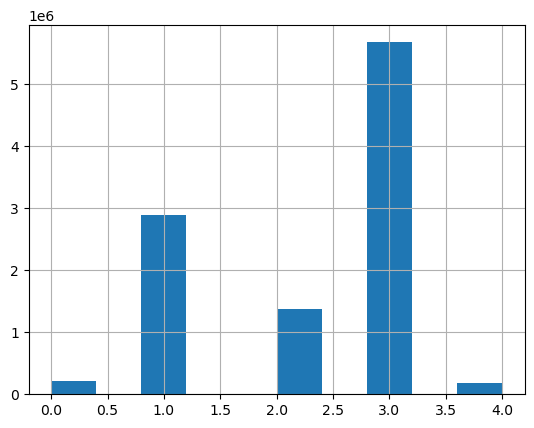

In [26]:
shizuoka['transport'].hist()

In [27]:
shizuoka_pseudo = dict()
idx = 0
for group in shizuoka.groupby(['origin_mesh', 'destn_mesh']):
    shizuoka_pseudo[idx] = [group[0][0], group[0][1], len(group[1])*10]
    idx += 1
shizuoka_pseudo = pd.DataFrame.from_dict(shizuoka_pseudo, orient='index')
shizuoka_pseudo.columns = ['origin', 'destination', 'volume']
shizuoka_pseudo

,origin,destination,volume
0,51364760,51365731,10
1,51365585,51365595,10
2,51365587,51365588,30
3,51365587,52370520,10
4,51365587,52371464,20
...,...,...,...
719860,54390330,52387765,10
719861,54392139,54392148,20
719862,54392148,52387798,10
719863,54392148,53380739,10


In [28]:
shizuoka_pseudo['origin'] = shizuoka_pseudo['origin'].astype(int)
shizuoka_pseudo['destination'] = shizuoka_pseudo['destination'].astype(int)

In [ ]:
shizuoka_pseudo_v1 = dict()
idx = 0
for group in shizuoka_ver1.groupby(['origin_mesh', 'destn_mesh']):
    shizuoka_pseudo_v1[idx] = [group[0][0], group[0][1], len(group[1])]
    idx += 1
shizuoka_pseudo_v1 = pd.DataFrame.from_dict(shizuoka_pseudo_v1, orient='index')
shizuoka_pseudo_v1.columns = ['origin', 'destination', 'volume']
shizuoka_pseudo_v1

In [27]:
shizuoka_pseudo_v1['origin'] = shizuoka_pseudo_v1['origin'].astype(int)
shizuoka_pseudo_v1['destination'] = shizuoka_pseudo_v1['destination'].astype(int)

In [ ]:
shizuoka_pseudo['volume'].sum() / shizuoka_pseudo_v1['volume'].sum()

In [29]:
shizuoka_sb = shizuoka_lv3_df[['origin_mesh_lv3', 'destination_mesh_lv3', 'total_people']]
shizuoka_sb = shizuoka_sb.rename(columns={"origin_mesh_lv3": "origin", 'destination_mesh_lv3': 'destination'})
shizuoka_sb

,origin,destination,total_people
0,51377589,51377598,1.0
1,51377589,51377599,1.0
2,51377589,51377682,50.0
3,51377589,52370509,36.7
4,51377589,52370518,96.8
...,...,...,...
115141,53390020,53380629,1.0
115142,53390020,53380716,1.0
115143,53390020,53380738,1.0
115144,53390020,53380739,13.2


In [ ]:
merged_df2 = pd.merge(shizuoka_sb, shizuoka_pseudo_v1, on=['origin', 'destination'], how='inner')
merged_df2

In [31]:
merged_df = pd.merge(shizuoka_sb, shizuoka_pseudo, on=['origin', 'destination'], how='inner')
merged_df

,origin,destination,total_people,volume
0,51377598,51377598,215.2,190
1,51377598,51377599,345.0,50
2,51377598,51377682,1.0,10
3,51377598,51377691,56.4,20
4,51377598,52370507,416.3,310
...,...,...,...,...
82183,53390020,52387777,1.0,30
82184,53390020,52387797,1.0,50
82185,53390020,53380716,1.0,40
82186,53390020,53380738,1.0,430


In [32]:
mape = np.mean(np.abs((merged_df['total_people'] - merged_df['volume']) / (merged_df['total_people']))) * 100
mape

6578.1215960447225

In [ ]:
merged_df2['total_people'].sum() , merged_df2['volume'].sum()

In [34]:
merged_df['total_people'].sum() , merged_df['volume'].sum()

(9853637.9, 65141690)

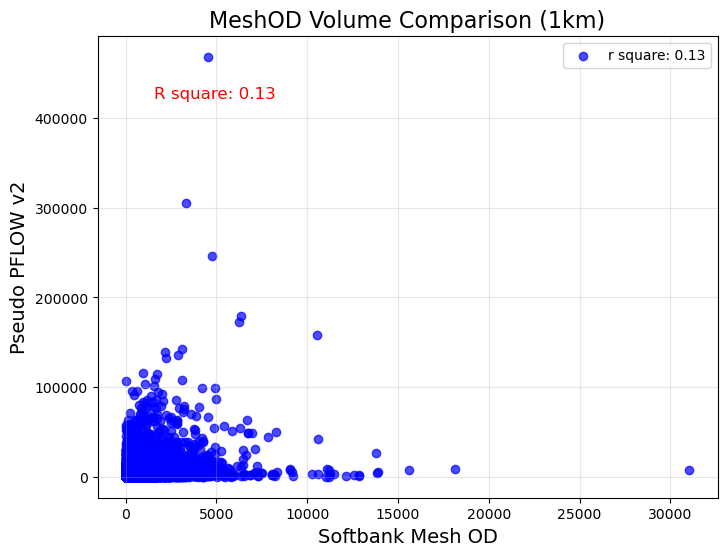

In [35]:
# 提取需要绘图的两列
x = merged_df['total_people']
y = merged_df['volume']

# 计算相关系数
correlation = np.corrcoef(x, y)[0, 1]  # 相关系数矩阵中的第一行第二列
r_square =  x.corr(y) ** 2

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7, label=f'r square: {r_square:.2f}')
plt.title('MeshOD Volume Comparison (1km)', fontsize=16)
plt.xlabel('Softbank Mesh OD', fontsize=14)
plt.ylabel('Pseudo PFLOW v2', fontsize=14)

# 在图上标注相关系数
plt.text(
    x.min() + (x.max() - x.min()) * 0.05,  # X 坐标，稍微偏移避免重叠
    y.max() - (y.max() - y.min()) * 0.1,  # Y 坐标，靠近顶部
    f'R square: {r_square:.2f}',
    fontsize=12,
    color='red'
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [41]:
zone_mesh_map = pd.read_csv('/home/owner/Downloads/22.csv', encoding='shift-jis').set_index('基準メッシュ・コード')['都道府県市区町村コード'].to_dict()
zone_mesh_map

{52383199: 22214,
 52383233: 22214,
 52383242: 22214,
 52383243: 22214,
 52383244: 22102,
 52383249: 22102,
 52383252: 22214,
 52383253: 22101,
 52383254: 22102,
 52383255: 22102,
 52383256: 22102,
 52383257: 22102,
 52383258: 22102,
 52383259: 22102,
 52383261: 22214,
 52383262: 22214,
 52383263: 22101,
 52383264: 22101,
 52383265: 22101,
 52383266: 22101,
 52383267: 22101,
 52383268: 22102,
 52383269: 22101,
 52383271: 22214,
 52383272: 22101,
 52383273: 22101,
 52383274: 22101,
 52383275: 22101,
 52383276: 22101,
 52383277: 22101,
 52383278: 22101,
 52383279: 22101,
 52383280: 22214,
 52383281: 22214,
 52383282: 22101,
 52383283: 22101,
 52383284: 22101,
 52383285: 22101,
 52383286: 22101,
 52383287: 22101,
 52383288: 22101,
 52383289: 22101,
 52383290: 22214,
 52383291: 22101,
 52383292: 22101,
 52383293: 22101,
 52383294: 22101,
 52383295: 22101,
 52383296: 22101,
 52383297: 22101,
 52383298: 22101,
 52383299: 22101,
 52383350: 22102,
 52383360: 22102,
 52383361: 22102,
 52383370:

In [42]:
cityname = pd.read_csv('/home/owner/Downloads/22.csv', encoding='shift-jis').set_index('都道府県市区町村コード')['市区町村名'].to_dict()
cityname

{22101: '静岡市葵区',
 22102: '静岡市駿河区',
 22103: '静岡市清水区',
 22131: '浜松市中区',
 22132: '浜松市東区',
 22133: '浜松市西区',
 22134: '浜松市南区',
 22135: '浜松市北区',
 22136: '浜松市浜北区',
 22137: '浜松市天竜区',
 22203: '沼津市',
 22205: '熱海市',
 22206: '三島市',
 22207: '富士宮市',
 22208: '伊東市',
 22209: '島田市',
 22210: '富士市',
 22211: '磐田市',
 22212: '焼津市',
 22213: '掛川市',
 22214: '藤枝市',
 22215: '御殿場市',
 22216: '袋井市',
 22219: '下田市',
 22220: '裾野市',
 22221: '湖西市',
 22222: '伊豆市',
 22223: '御前崎市',
 22224: '菊川市',
 22225: '伊豆の国市',
 22226: '牧之原市',
 22301: '東伊豆町',
 22302: '河津町',
 22304: '南伊豆町',
 22305: '松崎町',
 22306: '西伊豆町',
 22325: '函南町',
 22341: '清水町',
 22342: '長泉町',
 22344: '小山町',
 22424: '吉田町',
 22429: '川根本町',
 22461: '森町'}

In [43]:
merged_df['origin_city'] = merged_df['origin'].map(zone_mesh_map)
merged_df['destination_city'] = merged_df['destination'].map(zone_mesh_map)
merged_df2['origin_city'] = merged_df2['origin'].map(zone_mesh_map)
merged_df2['destination_city'] = merged_df2['destination'].map(zone_mesh_map)
merged_df2

,origin,destination,total_people,volume,origin_city,destination_city
0,51377598,51377598,215.2,85,22134,22134
1,51377598,51377599,345.0,1,22134,22134
2,51377598,52370507,416.3,16,22134,22134
3,51377598,52370509,271.6,5,22134,22134
4,51377598,52370516,13.3,3,22134,22134
...,...,...,...,...,...,...
81261,53390020,52387777,1.0,5,22344,22344
81262,53390020,52387797,1.0,4,22344,22344
81263,53390020,53380716,1.0,1,22344,22344
81264,53390020,53380738,1.0,40,22344,22344


In [ ]:
shizuoka_pseudo['origin_city'] = shizuoka_pseudo['origin'].map(zone_mesh_map)
shizuoka_pseudo['destination_city'] = shizuoka_pseudo['destination'].map(zone_mesh_map)
shizuoka_pseudo = shizuoka_pseudo.dropna()
shizuoka_pseudo['origin_cityname'] = shizuoka_pseudo['origin_city'].map(cityname)
shizuoka_pseudo['destination_cityname'] = shizuoka_pseudo['destination_city'].map(cityname)
shizuoka_pseudo

In [45]:
dfs = []
for city in cityname.values():
    print(city)
    city_df = shizuoka_pseudo[(shizuoka_pseudo['origin_cityname']==city)|(shizuoka_pseudo['destination_cityname']==city)]
    # print(city_df[(city_df['origin_cityname']==city) & (city_df['destination_cityname']!=city)])
    # print(city_df[city_df['origin_cityname']==city]['destination_cityname'].value_counts())
    
    pseudo_od = {}
    idx = 0

    for _, row in city_df.iterrows():
        if (row['origin_cityname']==city) & (row['destination_cityname'] == city):
            pseudo_od[idx] = ['20201001', '静岡県', city, row['origin'], 2, 2, row['origin'], row['origin'], row['destination'], row['destination'], row['volume']]
        elif  (row['origin_cityname']==city) & (row['destination_cityname'] != city):
            pseudo_od[idx] = ['20201001', '静岡県', city, row['origin'], 2, 3, row['origin'], row['origin'], row['destination_city'], row['destination_cityname'], row['volume']]
        else:
            pseudo_od[idx] = ['20201001', '静岡県', city, row['destination'], 3, 3, row['origin_city'], row['origin_cityname'], row['destination'], row['destination'], row['volume']]
        idx += 1

    pseudo_od_df = pd.DataFrame.from_dict(pseudo_od, orient='index', columns=['dt', 'pref_name', 'city_name', 'mesh_cd', 'od_class', 'trip_class', 'origin_agg_key_cd', 'origin_agg_key_name', 'destination_agg_key_cd', 'destination_agg_key_name', 'total_people'])
    dfs.append(pseudo_od_df)

静岡市葵区
静岡市駿河区
静岡市清水区
浜松市中区
浜松市東区
浜松市西区
浜松市南区
浜松市北区
浜松市浜北区
浜松市天竜区
沼津市
熱海市
三島市
富士宮市
伊東市
島田市
富士市
磐田市
焼津市
掛川市
藤枝市
御殿場市
袋井市
下田市
裾野市
湖西市
伊豆市
御前崎市
菊川市
伊豆の国市
牧之原市
東伊豆町
河津町
南伊豆町
松崎町
西伊豆町
函南町
清水町
長泉町
小山町
吉田町
川根本町
森町


In [46]:
shizuoka_pseudo_df = pd.concat(dfs, axis=0)
shizuoka_pseudo_df

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,total_people
0,20201001,静岡県,静岡市葵区,52383269,3,3,22223.0,御前崎市,52383269.0,52383269,20
1,20201001,静岡県,静岡市葵区,52384303,3,3,22213.0,掛川市,52384303.0,52384303,10
2,20201001,静岡県,静岡市葵区,52383279,3,3,22213.0,掛川市,52383279.0,52383279,10
3,20201001,静岡県,静岡市葵区,52384313,3,3,22223.0,御前崎市,52384313.0,52384313,10
4,20201001,静岡県,静岡市葵区,52383370,3,3,22223.0,御前崎市,52383370.0,52383370,10
...,...,...,...,...,...,...,...,...,...,...,...
3142,20201001,静岡県,森町,52372705,3,3,22103.0,静岡市清水区,52372705.0,52372705,10
3143,20201001,静岡県,森町,52372706,3,3,22103.0,静岡市清水区,52372706.0,52372706,10
3144,20201001,静岡県,森町,52371751,3,3,22103.0,静岡市清水区,52371751.0,52371751,10
3145,20201001,静岡県,森町,52371699,3,3,22210.0,富士市,52371699.0,52371699,10


In [47]:
shizuoka_pseudo_df = shizuoka_pseudo_df.sort_values(by=['city_name', 'od_class', 'trip_class'], ascending=[False, True, True])
shizuoka_pseudo_df

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,total_people
1081,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298.0,52382298,52382298.0,52382298,40
1082,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298.0,52382298,52383208.0,52383208,230
1083,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298.0,52382298,52383219.0,52383219,10
1160,20201001,静岡県,静岡市駿河区,52383207,2,2,52383207.0,52383207,52383207.0,52383207,130
1161,20201001,静岡県,静岡市駿河区,52383207,2,2,52383207.0,52383207,52383208.0,52383208,420
...,...,...,...,...,...,...,...,...,...,...,...
1030,20201001,静岡県,三島市,52385783,3,3,22344.0,小山町,52385783.0,52385783,10
1031,20201001,静岡県,三島市,52385763,3,3,22344.0,小山町,52385763.0,52385763,10
1032,20201001,静岡県,三島市,52385753,3,3,22344.0,小山町,52385753.0,52385753,10
1033,20201001,静岡県,三島市,52385743,3,3,22344.0,小山町,52385743.0,52385743,10


In [49]:
shizuoka_pseudo_df['origin_agg_key_cd'] = shizuoka_pseudo_df['origin_agg_key_cd'].astype(int)
shizuoka_pseudo_df['destination_agg_key_cd'] = shizuoka_pseudo_df['destination_agg_key_cd'].astype(int)
shizuoka_pseudo_df

,dt,pref_name,city_name,mesh_cd,od_class,trip_class,origin_agg_key_cd,origin_agg_key_name,destination_agg_key_cd,destination_agg_key_name,total_people
1081,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298,52382298,52382298,52382298,40
1082,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298,52382298,52383208,52383208,230
1083,20201001,静岡県,静岡市駿河区,52382298,2,2,52382298,52382298,52383219,52383219,10
1160,20201001,静岡県,静岡市駿河区,52383207,2,2,52383207,52383207,52383207,52383207,130
1161,20201001,静岡県,静岡市駿河区,52383207,2,2,52383207,52383207,52383208,52383208,420
...,...,...,...,...,...,...,...,...,...,...,...
1030,20201001,静岡県,三島市,52385783,3,3,22344,小山町,52385783,52385783,10
1031,20201001,静岡県,三島市,52385763,3,3,22344,小山町,52385763,52385763,10
1032,20201001,静岡県,三島市,52385753,3,3,22344,小山町,52385753,52385753,10
1033,20201001,静岡県,三島市,52385743,3,3,22344,小山町,52385743,52385743,10


In [50]:
shizuoka_pseudo_df.to_csv('/home/owner/Downloads/Pseudo_PFLOW_OD_SBSTYLE.csv', index=False)

In [51]:
shizuoka_pseudo

,origin,destination,volume,origin_city,destination_city,origin_cityname,destination_cityname
9,51377598,51377598,30,22134.0,22134.0,浜松市南区,浜松市南区
10,51377598,52370507,10,22134.0,22134.0,浜松市南区,浜松市南区
11,51377598,52370508,20,22134.0,22134.0,浜松市南区,浜松市南区
12,51377598,52370509,10,22134.0,22134.0,浜松市南区,浜松市南区
13,51377598,52370516,10,22134.0,22134.0,浜松市南区,浜松市南区
...,...,...,...,...,...,...,...
131048,53390021,53390020,30,22344.0,22344.0,小山町,小山町
131060,53390030,52387763,10,22344.0,22215.0,小山町,御殿場市
131061,53390030,53380739,30,22344.0,22344.0,小山町,小山町
131062,53390030,53390020,10,22344.0,22344.0,小山町,小山町


In [52]:
merged_df

,origin,destination,total_people,volume,origin_city,destination_city
0,51377598,51377598,215.2,30,22134,22134
1,51377598,52370507,416.3,10,22134,22134
2,51377598,52370509,271.6,10,22134,22134
3,51377598,52370516,13.3,10,22134,22134
4,51377598,52370517,195.4,10,22134,22134
...,...,...,...,...,...,...
35838,53380749,53380749,16.5,10,22344,22344
35839,53380758,53380738,110.6,30,22344,22344
35840,53390020,53380629,1.0,10,22344,22344
35841,53390020,53380738,1.0,60,22344,22344


In [53]:
pseudo_od = {}
idx = 0

for _, row in shizuoka_pseudo.iterrows():
    if row['origin_city'] == row['destination_city']:
        pseudo_od = ['20201001', '静岡県', row['origin'], 2, 2, row['origin_cityname'], row['origin'], row['origin'], row['destination'], row['destination'], row['volume']]
    else:
        pseudo_od = ['20201001', '静岡県', row['origin'], 2, 3, row['origin_cityname'], row['origin'], row['origin'], row['destination'], row['destination'], row['volume']]
    idx += 1

In [54]:
merged_df_city2 = (
    merged_df2.groupby(["origin_city", "destination_city"], as_index=False)  # 分组，并保留列作为 DataFrame
    .agg(
        {'total_people': 'sum',
         'volume': 'sum'}  # 汇总人口列
    ) 
)
merged_df_city2

,origin_city,destination_city,total_people,volume
0,22101,22101,386076.7,289986
1,22101,22102,36753.0,81014
2,22101,22103,8755.1,9059
3,22101,22429,13.9,2
4,22102,22101,36964.7,77031
...,...,...,...,...
208,22429,22429,5386.8,152
209,22461,22211,2300.4,175
210,22461,22213,3597.3,175
211,22461,22216,5318.3,1619


In [55]:
merged_df_city = (
    merged_df.groupby(["origin_city", "destination_city"], as_index=False)  # 分组，并保留列作为 DataFrame
    .agg(
        {'total_people': 'sum',
         'volume': 'sum'}  # 汇总人口列
    ) 
)
merged_df_city

,origin_city,destination_city,total_people,volume
0,22101,22101,333478.6,287510
1,22101,22102,34795.5,203250
2,22101,22103,8252.4,6430
3,22102,22101,34940.6,59770
4,22102,22102,387412.6,1087610
...,...,...,...,...
172,22429,22429,1727.7,740
173,22461,22211,624.7,120
174,22461,22213,537.4,280
175,22461,22216,2737.2,1330


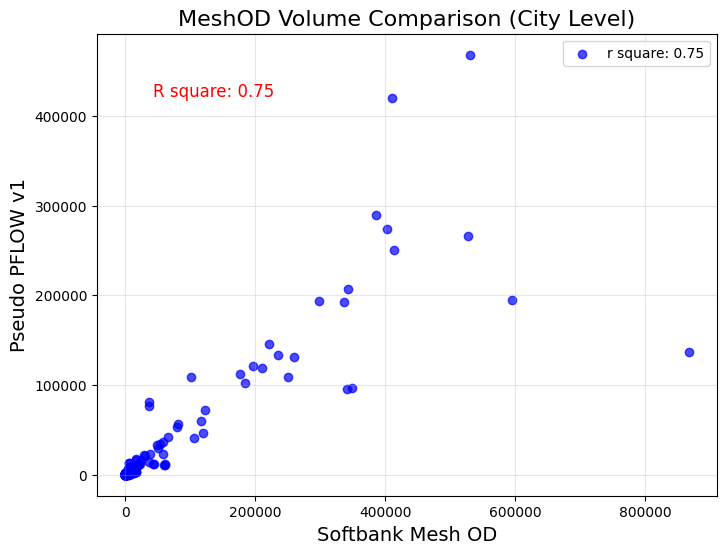

In [64]:
# 提取需要绘图的两列
x = merged_df_city2['total_people']
y = merged_df_city2['volume']

# 计算相关系数
correlation = np.corrcoef(x, y)[0, 1]  # 相关系数矩阵中的第一行第二列
r_square =  x.corr(y) ** 2

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.7, label=f'r square: {r_square:.2f}')
plt.title('MeshOD Volume Comparison (City Level)', fontsize=16)
plt.xlabel('Softbank Mesh OD', fontsize=14)
plt.ylabel('Pseudo PFLOW v1', fontsize=14)

# 在图上标注相关系数
plt.text(
    x.min() + (x.max() - x.min()) * 0.05,  # X 坐标，稍微偏移避免重叠
    y.max() - (y.max() - y.min()) * 0.1,  # Y 坐标，靠近顶部
    f'R square: {r_square:.2f}',
    fontsize=12,
    color='red'
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [65]:
mape = np.mean(np.abs((merged_df_city2['total_people'] - merged_df_city2['volume']) / merged_df_city2['total_people'])) * 100
mape

83.34589619274956

In [66]:
mape = np.mean(np.abs((merged_df_city['total_people'] - merged_df_city['volume']) / merged_df_city['total_people'])) * 100
mape

256.5776078098343

In [72]:
merged_df_city[(merged_df_city['total_people']>50000) & (merged_df_city['volume']<10000)]

,origin_city,destination_city,total_people,volume
99,22213,22213,143726.9,2319
115,22215,22215,153756.2,1463
119,22216,22216,122215.2,4522
125,22220,22220,61152.5,2637
132,22221,22221,232738.6,3280
206,22461,22461,52136.0,9532


In [69]:
merged_df_city2[(merged_df_city2['origin_city']==22216) & (merged_df_city2['origin_city']==22216)]

,origin_city,destination_city,total_people,volume
120,22216,22211,17317.6,2830
121,22216,22213,4214.6,968
122,22216,22216,202029.4,102714
123,22216,22224,10.0,1
124,22216,22461,6689.7,1599


In [68]:
merged_df_city2['total_people'].sum() , merged_df_city2['volume'].sum()

(9853653.799999999, 5400525)

In [39]:
idx = 0
od_volume = {}

In [44]:
zones = gpd.read_file('/home/ubuntu/Data/shapefile/ShizuokaZone/N03-20210101_22_GML/N03-21_22_210101.shp')
zones = zones.drop(['N03_002'], axis=1).rename(columns={'N03_007': 'ZONE_ID'})

for group in shizuoka_pseudo.groupby('origin'):
    slat, slon = ju.to_meshpoint(group[0], 0.5, 0.5)
    p_start = gpd.GeoSeries(Point(slon, slat))
    zone = zones[zones.contains(p_start.geometry.iloc[0])]['ZONE_ID']
    if len(zone) > 0:
        ozone = zone.values[0]
    else:
        continue
        
    for idx, row in group[1].iterrows():
        elat, elon = ju.to_meshpoint(row['destination'], 0.5, 0.5)
        p_end = gpd.GeoSeries(Point(elon, elat))
        zone_ = zones[zones.contains(p_end.geometry.iloc[0])]['ZONE_ID']
        if len(zone_) > 0:
            dzone = zone_.values[0]
        else:
            continue
        if (ozone, dzone) not in od_volume:
            od_volume[(ozone, dzone)] = 0
        od_volume[(ozone, dzone)] += 1
        
# for idx, row in shizuoka_pseudo.iterrows(): 
#     if idx % 1000 == 0:
#         print(idx)
#     try:
#         slat, slon = ju.to_meshpoint(row['origin'], 0.5, 0.5)
#         p_start = gpd.GeoSeries(Point(slat, slon))
#         ozone = zones[zones.contains(p_start.geometry.iloc[0])]['ZONE_ID'].values[0]
#         print(ozone)
#         elat, elon = ju.to_meshpoint(row['destination'], 0.5, 0.5)
#         p_end = gpd.GeoSeries(Point(elat, elon))
#         dzone = zones[zones.contains(p_end.geometry.iloc[0])]['ZONE_ID'].values[0]
#         if (ozone, dzone) not in od_volume:
#             od_volume[(ozone, dzone)] = 0
#         od_volume[(ozone, dzone)] += 1
        
#     except IndexError:
#         i = 0

In [45]:
shizuoka = pd.DataFrame.from_dict(od_volume, orient='index').reset_index().rename(columns={'index':'od', 0:'volume'})
shizuoka['origin'], shizuoka['destination'] = shizuoka.od.str
shizuoka = shizuoka[['origin', 'destination', 'volume']]
shizuoka.to_csv('Softbank/shizuoka_pseudo_zone_od.csv', index=False)

/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


<AxesSubplot:>

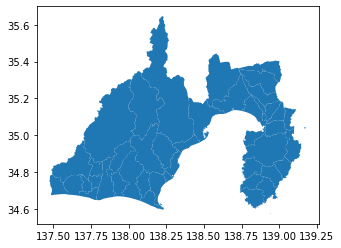

In [27]:
zones.plot()